**Unet model to remove artifacts from the sparseview images**.

This project uses Keras API and Tensorflow 1.15 to implement the original Unet model.
Planning to upgrade code to tensorflow 2.X. Some part of code might be from Google course on Tensorflow with Laurence Moroney.

In [27]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To keep using Tensoftlow 1.15 need the code below. By defaut the colab will start using Tnsorflow 2.X

In [28]:
# %tensorflow_version 1.x
# import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:

import os
import zipfile
import random
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Concatenate
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Input, Dense
from keras.layers import BatchNormalization, Activation, Dropout, Subtract
from keras.models import Model
from glob import glob
from keras.layers.convolutional import Conv2DTranspose
from keras.layers import concatenate




If we have weights we can downoad weight without training a model. loaded_model.load_weights("model.h5")


In [0]:
# loaded_model.load_weights("model.h5")

In [0]:
print(len(os.listdir('/content/drive/My Drive/Colab Notebooks/CT_data/sparseview_60/train')))
print(len(os.listdir('/content/drive/My Drive/Colab Notebooks/CT_data/ndct/train')))
# 3600
# 3600

3600
3600


In [0]:
print(len(os.listdir('/content/drive/My Drive/Colab Notebooks/CT_data/sparseview_60/test/')))
print(len(os.listdir('/content/drive/My Drive/Colab Notebooks/CT_data/ndct/test/')))
# # 354
# # 354

354
354


In [30]:
ndct = sorted(glob('/content/drive/My Drive/Colab Notebooks/CT_data/ndct/train/*'))
ldct = sorted(glob('/content/drive/My Drive/Colab Notebooks/CT_data/sparseview_60/train/*'))

ndct_test = sorted(glob('/content/drive/My Drive/Colab Notebooks/CT_data/ndct/test/*'))
ldct_test = sorted(glob('/content/drive/My Drive/Colab Notebooks/CT_data/sparseview_60/test/*'))

print(len(ndct))
print(len(ldct))
print(len(ndct_test))
print(len(ldct_test))

3600
3600
354
354


The formulas below will be used to calculate the quality of the reconstruction. Higher PSNR generally indicates high quality of reconstruction.

In [0]:
def cal_psnr(im1, im2):
    # assert pixel value range is 0-255 and type is uint8
    mse = ((im1.astype(np.float) - im2.astype(np.float)) ** 2).mean()
    maxval = np.amax(im1)
    psnr = 10 * np.log10(maxval ** 2 / mse)
    return psnr

def tf_psnr(im1, im2):
    # assert pixel value range is 0-1
    #mse = tf.losses.mean_squared_error(labels=im2 * 255.0, predictions=im1 * 255.0)
    mse = tf.compat.v1.losses.mean_squared_error(labels=im2 * 255.0, predictions=im1 * 255.0)
    return 10.0 * (tf.log(255.0 ** 2 / mse) / tf.log(10.0))

Useing less data: #for i in range(0, 600). Have 3600 in all.
Processing 3600 images takes aprox. 20 minutes to run. But once we create .npy aray we don't have to rerun this code in the future and we will have .npy form of our data. Colab has 11GB RAM limit.

In [32]:
ndct_imgs_train = []
# for i in range(0, len(ndct)):                                                                                                                                      
for i in range(0, 600):
    f = open(ndct[i],'rb')
    a = np.fromfile(f, np.float32)
    ndct_imgs_train.append(a)
    f.close()
print("len(ndct_imgs_train)....: ",len(ndct_imgs_train))
#len(ndct_imgs_train)....:  3600                                                                                                                                                         

len(ndct_imgs_train)....:  600



Using different range to use less data to train #for i in range(0, 600). In all have 3600 images. It takes aprox. 20 minutes to process all 3600. But once we create .npy aray we don't have to rerun this code in the future and we will have .npy form of our data.

In [33]:
ldct_imgs_train = []
# for i in range(0, len(ldct)):
for i in range(0, 600):
    f = open(ldct[i],'rb')
    a = np.fromfile(f, np.float32)
    ldct_imgs_train.append(a)
    f.close()
print("len(ldct_imgs_train)....: ",len(ldct_imgs_train))

len(ldct_imgs_train)....:  600


only using 100 images to test. In total we have 354 testing images.

In [38]:
ndct_imgs_test = []
# for i in range(0, len(ndct_test)):
for i in range(0, 100):
    f = open(ndct_test[i],'rb')
    a = np.fromfile(f, np.float32)
    ndct_imgs_test.append(a)
    f.close()
print("len(ndct_imgs_test)....: ",len(ndct_imgs_test))


len(ndct_imgs_test)....:  100


only using 100 images to test. In total we have 354 images

In [36]:
# load the image
ldct_imgs_test = []
# for i in range(0, len(ldct_test)):
for i in range(0, 100):
    f = open(ldct_test[i],'rb')
    a = np.fromfile(f, np.float32)
    ldct_imgs_test.append(a)
    f.close()
print("len(ldct_imgs_test)....: ",len(ldct_imgs_test))


len(ldct_imgs_test)....:  100


Must reshape images to train

In [39]:
ldct_train = np.asarray(ldct_imgs_train)
ndct_train = np.asarray(ndct_imgs_train)

ldct_train = ldct_train.reshape(600,512,512,1)
ndct_train = ndct_train.reshape(600,512,512,1)

ldct_test = np.asarray(ldct_imgs_test)
ndct_test = np.asarray(ndct_imgs_test)

# ldct_test = ldct_test.reshape(len(ldct_imgs_test),512,512,1)
# ndct_test = ndct_test.reshape(len(ldct_imgs_test),512,512,1)

ldct_test = ldct_test.reshape(100,512,512,1)
ndct_test = ndct_test.reshape(100,512,512,1)

print(ldct_train.shape)
print(ndct_train.shape)
print(ldct_test.shape)
print(ndct_test.shape)


(600, 512, 512, 1)
(600, 512, 512, 1)
(100, 512, 512, 1)
(100, 512, 512, 1)


In [0]:
# np.save('sparseview_60_train_600', ldct_train) # save the file as "sparseview_60_train.npy" 
# np.save('ndct_train_600', ndct_train) # save the file as "ndct_train.npy" 

# np.save('sparseview_60_test_100', ldct_test) # save the file as "sparseview_60_test.npy" 
# np.save('ndct_test_100', ndct_test) # save the file as "ndct_test.npy" 


np.save('/content/drive/My Drive/Colab Notebooks/unet_15/sparseview_60_train_600', ldct_train) # save the file as "sparseview_60_train.npy" 
np.save('/content/drive/My Drive/Colab Notebooks/unet_15/ndct_train_600', ndct_train) # save the file as "ndct_train.npy" 

np.save('/content/drive/My Drive/Colab Notebooks/unet_15/sparseview_60_test_100', ldct_test) # save the file as "sparseview_60_test.npy" 
np.save('/content/drive/My Drive/Colab Notebooks/unet_15/ndct_test_100', ndct_test) # save the file as "ndct_test.npy"

In [0]:
sparseview_60_train = np.load('/content/drive/My Drive/Colab Notebooks/unet_15/sparseview_60_train_600.npy') # loads saved array into variable sparseview_60_train.
ndct_train = np.load('/content/drive/My Drive/Colab Notebooks/unet_15/ndct_train_600.npy') # loads saved array into variable ndct_train.
sparseview_60_test = np.load('/content/drive/My Drive/Colab Notebooks/unet_15/sparseview_60_test_100.npy') # loads saved array into variable sparseview_60_test.
ndct_test = np.load('/content/drive/My Drive/Colab Notebooks/unet_15/ndct_test_100.npy') # loads saved array into variable ndct_test.

# sparseview_60_train = np.load('sparseview_60_train_600.npy') # loads saved array into variable sparseview_60_train.
# ndct_train = np.load('ndct_train_600.npy') # loads saved array into variable ndct_train.
# sparseview_60_test = np.load('sparseview_60_test_100.npy') # loads saved array into variable sparseview_60_test.
# ndct_test = np.load('ndct_test_100.npy') # loads saved array into variable ndct_test.


Basic UNet model

In [0]:
inputs = Input((None, None,1))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)


c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)


u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

output_img = Conv2D(1, (1, 1)) (c9)
subtracted = Subtract()([inputs, output_img])
# subtracted = keras.layers.Subtract()([net, output_img])

unet_15_model = Model(inputs=[inputs], outputs=[subtracted])
unet_15_model.compile(optimizer='adam', loss='mse', metrics=[tf_psnr])



In [54]:
unet_15_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, None, None, 8 80          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, None, None, 8 584         conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, None, None, 8 0           conv2d_59[0][0]                  
____________________________________________________________________________________________

In [44]:
history=unet_15_model.fit(sparseview_60_train, ndct_train, validation_split=0.05, batch_size=10, epochs=40)


Train on 570 samples, validate on 30 samples
Epoch 1/40
570/570 [==============================] - 8s 14ms/step - loss: 0.0011 - tf_psnr: 29.8746 - val_loss: 6.0528e-04 - val_tf_psnr: 32.1868
Epoch 2/40
570/570 [==============================] - 6s 11ms/step - loss: 6.4226e-04 - tf_psnr: 31.9359 - val_loss: 4.4407e-04 - val_tf_psnr: 33.5280
Epoch 3/40
570/570 [==============================] - 6s 11ms/step - loss: 5.5474e-04 - tf_psnr: 32.5680 - val_loss: 3.7929e-04 - val_tf_psnr: 34.2114
Epoch 4/40
570/570 [==============================] - 6s 11ms/step - loss: 5.1210e-04 - tf_psnr: 32.9381 - val_loss: 3.5278e-04 - val_tf_psnr: 34.5253
Epoch 5/40
570/570 [==============================] - 6s 11ms/step - loss: 4.2431e-04 - tf_psnr: 33.7333 - val_loss: 3.5429e-04 - val_tf_psnr: 34.5068
Epoch 6/40
570/570 [==============================] - 6s 11ms/step - loss: 3.5475e-04 - tf_psnr: 34.5162 - val_loss: 3.0247e-04 - val_tf_psnr: 35.1934
Epoch 7/40
570/570 [==============================] -

Save weights for the future reuse.

In [0]:
unet_15_model.save_weights("/content/drive/My Drive/Colab Notebooks/unet_15/model.h5")

Plotting PSNR values to see the trend.

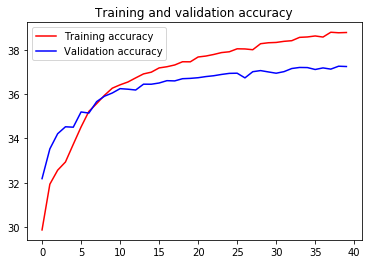

<Figure size 432x288 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt
acc = history.history['tf_psnr']
val_acc = history.history['val_tf_psnr']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [47]:
reconstructed = unet_15_model.predict(sparseview_60_test)
psnr = cal_psnr(ndct_test, reconstructed)
print("psnr 40 epochs.....",psnr)

psnr 40 epochs..... 34.96571490414341


Save images to a folder

In [0]:
from PIL import Image

a = reconstructed[0].reshape(512, 512)
scalef = np.amax(a)
a = np.clip(255 * a/scalef, 0, 255).astype('uint8')
#result = Image.fromarray((a * 255).astype(np.uint8))                                                                                                
result = Image.fromarray((a).astype(np.uint8))
# result.save('unet_15_600_0.png')
result.save('/content/drive/My Drive/Colab Notebooks/unet_15/reconstructed_unet_15_0.png')

a = reconstructed[99].reshape(512, 512)
scalef = np.amax(a)
a = np.clip(255 * a/scalef, 0, 255).astype('uint8')
#result = Image.fromarray((a * 255).astype(np.uint8))                                                                                                
result = Image.fromarray((a).astype(np.uint8))
# result.save('unet_15_600_99.png')
result.save('/content/drive/My Drive/Colab Notebooks/unet_15/reconstructed_unet_15_99.png')

Save original sparseview images to a folder

In [0]:
a = sparseview_60_test[0].reshape(512, 512)
scalef = np.amax(a)
a = np.clip(255 * a/scalef, 0, 255).astype('uint8')
#result = Image.fromarray((a * 255).astype(np.uint8))                                                                                                
result = Image.fromarray((a).astype(np.uint8))
# result.save('unet_15_600_0.png')
result.save('/content/drive/My Drive/Colab Notebooks/unet_15/sparseview_60_test_unet_15_0.png')

a = sparseview_60_test[99].reshape(512, 512)
scalef = np.amax(a)
a = np.clip(255 * a/scalef, 0, 255).astype('uint8')
#result = Image.fromarray((a * 255).astype(np.uint8))                                                                                                
result = Image.fromarray((a).astype(np.uint8))
# result.save('unet_15_600_99.png')
result.save('/content/drive/My Drive/Colab Notebooks/unet_15/sparseview_60_test_unet_15_99.png')

Plot model acuracy

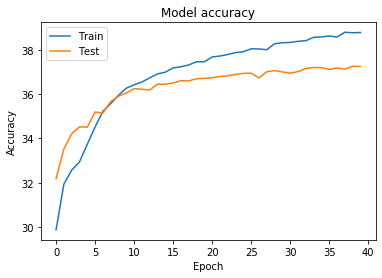

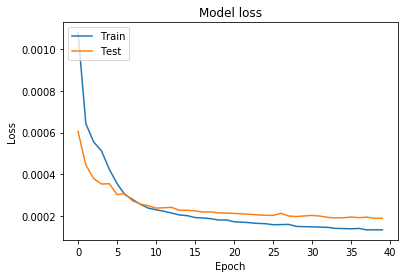

In [50]:
# Plot training & validation accuracy values
plt.plot(history.history['tf_psnr'])
plt.plot(history.history['val_tf_psnr'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Output images

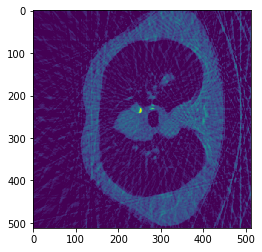

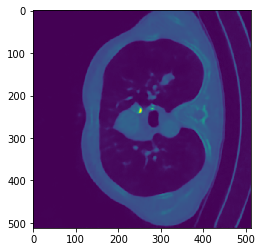

In [58]:
img=mpimg.imread('/content/drive/My Drive/Colab Notebooks/unet_15/sparseview_60_test_unet_15_0.png')
imgplot = plt.imshow(img)
plt.show()
img=mpimg.imread('/content/drive/My Drive/Colab Notebooks/unet_15/reconstructed_unet_15_0.png')
imgplot = plt.imshow(img)
plt.show()

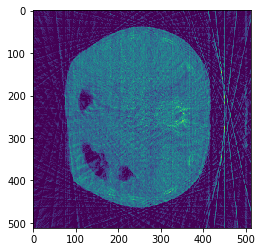

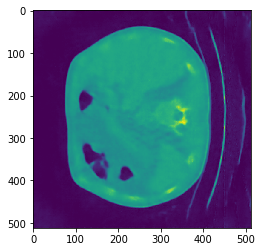

In [59]:
img=mpimg.imread('/content/drive/My Drive/Colab Notebooks/unet_15/sparseview_60_test_unet_15_99.png')
imgplot = plt.imshow(img)
plt.show()
img=mpimg.imread('/content/drive/My Drive/Colab Notebooks/unet_15/reconstructed_unet_15_99.png')
imgplot = plt.imshow(img)
plt.show()